# Noisy Deconvolution

Let's see how well we can recover an image from noisy, linear samples. We'll start by trying to reconstruct an image that is corrupted by a Gaussian blur.

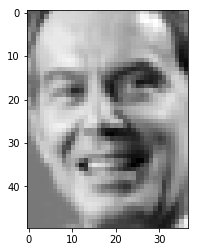

In [111]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
this_face = lfw_people.images[400]
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

height = this_face.shape[0]
width = this_face.shape[1]
size = height*width

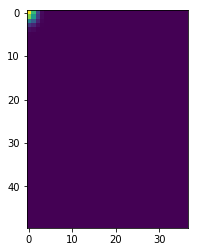

In [119]:
#First, we need to build the impulse response of the blur.

scale = 5
t = np.linspace(0, 10, height)
s = np.linspace(0, 10, width)
vert = np.exp(-scale*t**2)
#vert /= np.sum(vert) # normalize the impulse response
horiz = np.exp(-scale*s**2)
#horiz /= np.sum(horiz)
kernel =  np.outer(vert, horiz) #make a 2D impulse response
h = kernel.flatten()

#Now we need to make a matrix operator out of it.
H = sp.linalg.toeplitz(h)

plt.imshow(kernel)
plt.show()

Above you can see the 2D impulse response of the blur filter, which you can adjust via the 'scale' variable. Let's construct our blurred, noisy image.

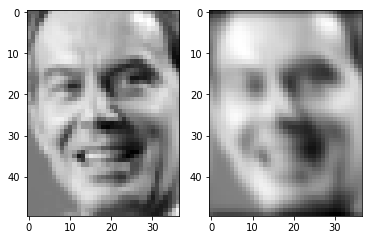

In [120]:
sigma_2 = 0.01 #noise variance
x = this_face.flatten() #treat the image as a vector
y = H@x + np.sqrt(sigma_2)*np.random.randn(size)

y_image = np.reshape(y,(height,width))

sub = plt.subplot(1,2,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,2,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

The ML estimate is to take the pseudo-inverse of y. Let's see how well it works.

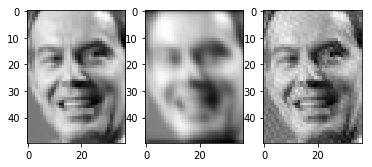

In [121]:
x_hat = np.linalg.pinv(H)@y
x_hat_image = np.reshape(x_hat,(height, width))

sub = plt.subplot(1,3,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

It did... okay! It has made the image look crisper, but we still have lost a lot of the original details and introduced artifacts.

Next, let's try an example where ML estimation will do badly. *Inpainting* is the process of filling in pixels that are missing due to sensor failure or other corruptions. In this case, the measurement matrix is a simple diagonal matrix with ones where the pixels are preserved, and zeros where they are lost.

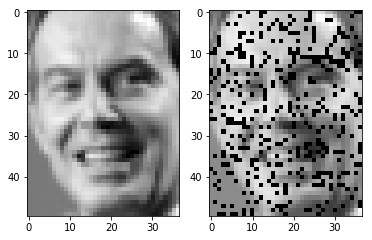

In [122]:
loss_ratio = 0.2
h = np.random.binomial(1,1-loss_ratio,size)
H = np.diag(h)

y = H@x + np.sqrt(sigma_2)*np.random.randn(size)
y_image = np.reshape(y,(height,width))

sub = plt.subplot(1,2,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,2,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

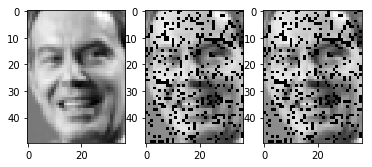

In [123]:
x_hat = np.linalg.pinv(H)@y
x_hat_image = np.reshape(x_hat,(height, width))

sub = plt.subplot(1,3,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

The reconstructed image is exactly the same! Why did this go so badly? We need to assume some prior structure on the image if we want to fill in the missing pixels. When we study Bayes estimation, we'll see how to do exactly that.

One more important case is estimating from a *random* measurement matrix. This is the basic idea behind the field of **compressive sensing**, where only a few measurements from a signal/image are used in order to limit the size and complexity of the signal representation.

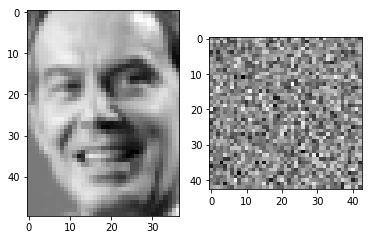

In [153]:
m = 43 #measurement image height and width
H = np.random.randn(m**2,size)

y = H@x + np.sqrt(sigma_2)*np.random.randn(m**2)
y_image = np.reshape(y,(m,m))

sub = plt.subplot(1,2,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,2,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

The "noisy" image doesn't look like the original at all, and it shouldn't. We've reduced its dimension, and we can't display it as an image of the same size. Still, we can find the ML estimate of the original by taking the pseudo-inverse. Let's see how well it works.

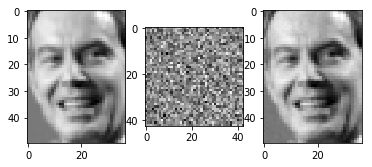

In [154]:
x_hat = np.linalg.pinv(H)@y
x_hat_image = np.reshape(x_hat,(height, width))

sub = plt.subplot(1,3,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

We can experiment with the size m. It turns out that the original image has 1850 pixels, and if we take m = sqrt(1850) = ~43, the ML estimate does a good job reconstructing the image. However, if we take fewer measurements, the quality falls off very, very quickly. If we want to do better -- and in practice we can do much, much better than this -- we need to make prior assumptions about the structure of the image. Again, we'll see this in detail when we study Bayes estimation.